In [316]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time


In [317]:
torch.set_default_device('cpu')
torch.get_default_device()

device(type='cpu')

In [318]:
def set_seed():
    SEED_VALUE = 42
    
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
set_seed()

In [319]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = True, transform = transform)
val_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = False, transform = transform) #Test set

print('Total Train Images: ', len(train_set))
print('Total Val Images: ', len(val_set))

Total Train Images:  60000
Total Val Images:  10000


In [320]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=64)

In [331]:
for images, labels in train_loader:
    print(len(images))
    print(labels.size(0))
    break

64
64


In [321]:
#class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

images.shape >  torch.Size([64, 1, 28, 28])
labels.shape >  torch.Size([64])


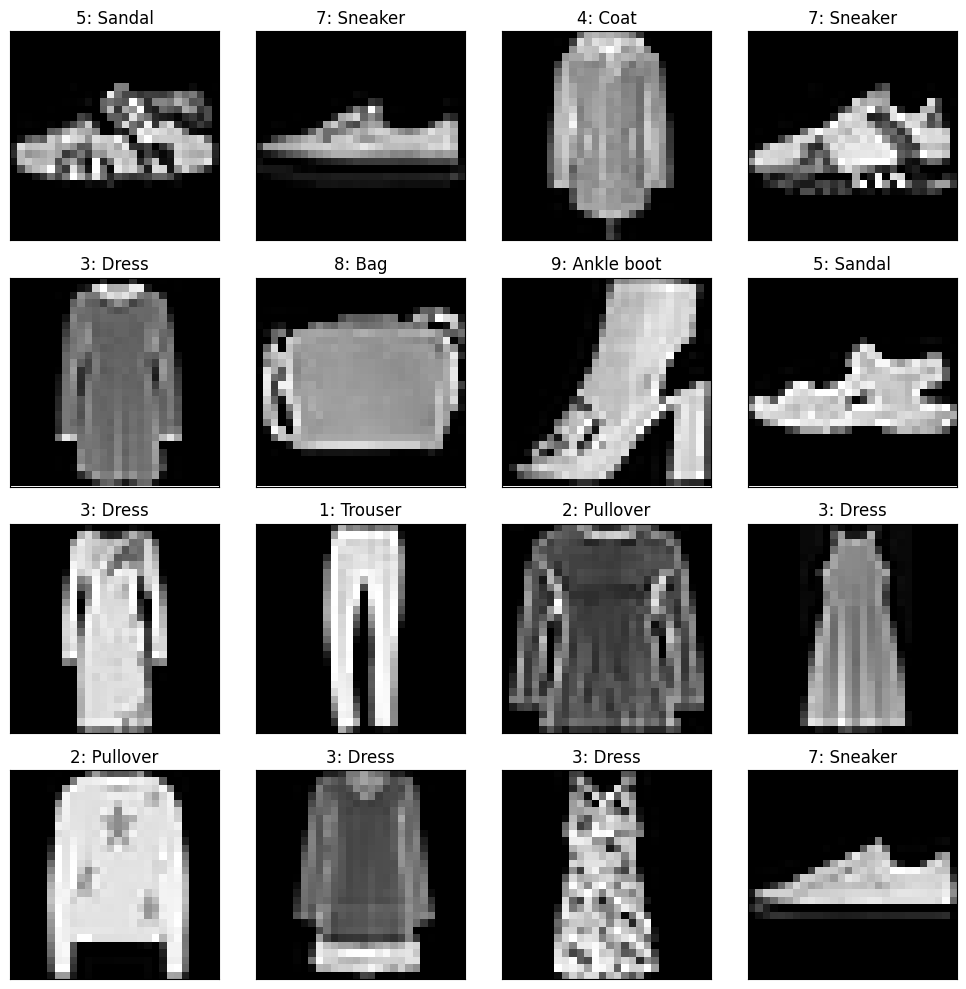

In [322]:
def visualize_image(train_loader, num_images=20):
    fig = plt.figure(figsize=(10, 10))
    images, labels = next(iter(train_loader))
    print('images.shape > ', images.shape)
    print('labels.shape > ', labels.shape)
    
    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))
    
    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(image), cmap='gray')
        ax.set_title(f'{label.item()}: {class_mapping[label.item()]}')
    
    fig.tight_layout()
    plt.show()
    
visualize_image(train_loader, num_images=16)

In [323]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # self.f = nn.Flatten()
        self.fc0 = nn.Linear(784, 512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        # x = self.f(x)
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn1(self.fc1(x)))
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

mlp_model = MLP(num_classes=10)
        

In [324]:
print(summary(mlp_model, input_size=(1,1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  401,920
├─BatchNorm1d: 1-2                       [1, 512]                  1,024
├─Dropout: 1-3                           [1, 512]                  --
├─Linear: 1-4                            [1, 256]                  131,328
├─BatchNorm1d: 1-5                       [1, 256]                  512
├─Linear: 1-6                            [1, 128]                  32,896
├─BatchNorm1d: 1-7                       [1, 128]                  256
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 64]                   8,256
├─BatchNorm1d: 1-10                      [1, 64]                   128
├─Linear: 1-11                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

In [325]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2)
num_epochs = 40
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [ ]:
def train(model, train_loader, criterion, optimizer, DEVICE):
    model.train()   # 훈련 
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()   # 옵티마이저 초기화
        outputs = model(images) # 모델에 입력
        loss = criterion(outputs, labels)   # 로스 함수 생성
        loss.backward() # 역전파
        optimizer.step()    # 옵티마이저 업데이트
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [ ]:
def validation(model, val_loader, criterion, DEVICE):
    model.eval()    # 평가
    model.to(DEVICE)
    
    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():   # 가중치 설정 제외
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            output = model(images)  # 모델에 입력
            loss = criterion(output, labels) # 로스 함수 생성
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [328]:
def main(model, train_loader, val_loader, epochs=5, DEVICE='mps'):
    train_losses, val_losses = [], []
    train_accuracy, val_accuracy = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = validation(model, val_loader, criterion, DEVICE)
        
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        
        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    x = range(1, epochs+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, train_losses, label='Train_Loss')
    plt.plot(x, val_losses, label='Val_Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, train_accuracy, label='Train_Acc')
    plt.plot(x, val_accuracy, label='Val_Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

Epoch 01/40 - Train Loss: 0.5566, Train Accuracy: 80.22% - Val Loss: 0.4282, Val Accuracy: 53031.25%
Epoch 02/40 - Train Loss: 0.4366, Train Accuracy: 84.44% - Val Loss: 0.3902, Val Accuracy: 53406.25%
Epoch 03/40 - Train Loss: 0.3978, Train Accuracy: 85.77% - Val Loss: 0.3681, Val Accuracy: 54018.75%
Epoch 04/40 - Train Loss: 0.3741, Train Accuracy: 86.61% - Val Loss: 0.3527, Val Accuracy: 54493.75%
Epoch 05/40 - Train Loss: 0.3548, Train Accuracy: 87.23% - Val Loss: 0.3418, Val Accuracy: 54912.50%
Epoch 06/40 - Train Loss: 0.3393, Train Accuracy: 87.79% - Val Loss: 0.3413, Val Accuracy: 54656.25%
Epoch 07/40 - Train Loss: 0.3253, Train Accuracy: 88.15% - Val Loss: 0.3274, Val Accuracy: 55106.25%
Epoch 08/40 - Train Loss: 0.3137, Train Accuracy: 88.66% - Val Loss: 0.3164, Val Accuracy: 55262.50%
Epoch 09/40 - Train Loss: 0.3018, Train Accuracy: 89.07% - Val Loss: 0.3215, Val Accuracy: 55181.25%
Epoch 10/40 - Train Loss: 0.2897, Train Accuracy: 89.40% - Val Loss: 0.3077, Val Accuracy: 

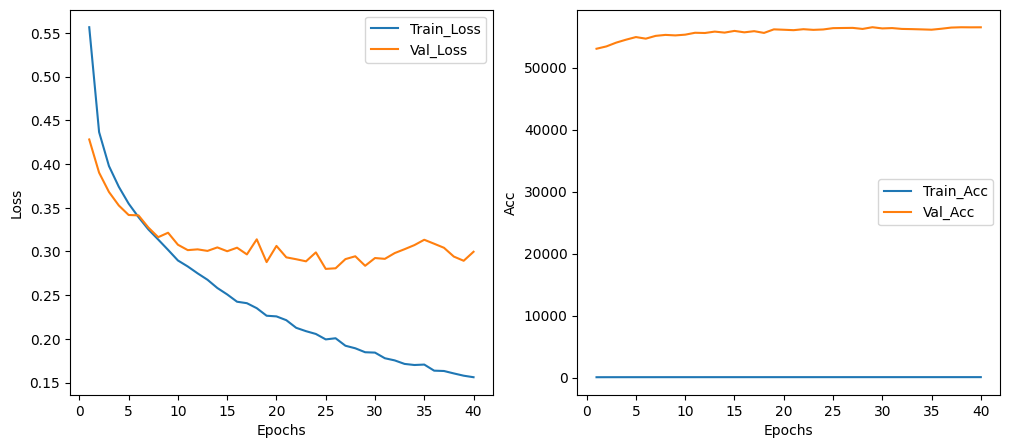

In [329]:
main(mlp_model, train_loader, val_loader, num_epochs, DEVICE=DEVICE)

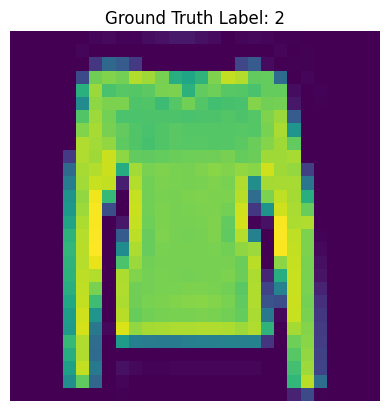

In [333]:
images, gt_labels = next(iter(val_loader))
rand_idx = random.choice(range(len(images)))

plt.imshow(np.squeeze(images[rand_idx]))
plt.title('Ground Truth Label: ' + str(int(gt_labels[rand_idx])), fontsize=12)
plt.axis('off')
plt.show()

In [334]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

In [ ]:
mlp_model.eval()    # 평가

with torch.no_grad():   # 가중치 설정 제외
    batch_outputs = mlp_model(images.to(DEVICE))    # 모델에 입력

print('batch_outputs shape : ', batch_outputs.shape)
prob_score_batch = batch_outputs.softmax(dim=1).cpu()   # softmax 로 분류
print('prob_score_batch\n\n', prob_score_batch.shape)

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print('Predictions for each class on the test image:\n')
print(prob_score_test_image.shape)

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
        print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
        print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

batch_outputs shape :  torch.Size([64, 10])
prob_score_batch

 torch.Size([64, 10])
Predictions for each class on the test image:

torch.Size([10])
Class: 0 - T-shirt/top, Probability: 0.002
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.965
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.021
Class: 5 - Sandal, Probability: 0.001
Class: 6 - Shirt, Probability: 0.005
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.006
Class: 9 - Ankle boot, Probability: 0.000


In [355]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def prediction_batch(model, batch_inputs):
    model.eval() # 평가
    
    batch_outputs = model(batch_inputs)
    
    with torch.no_grad(): # 가중치 업데이트 제외
        batch_probs = batch_outputs.softmax(dim=1)
    
    batch_cls_ids = batch_probs.argmax(dim=1)
    
    return batch_cls_ids.cpu()

In [ ]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)
    
    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)
    
    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)
    
val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

[1 4 1 ... 9 9 6]


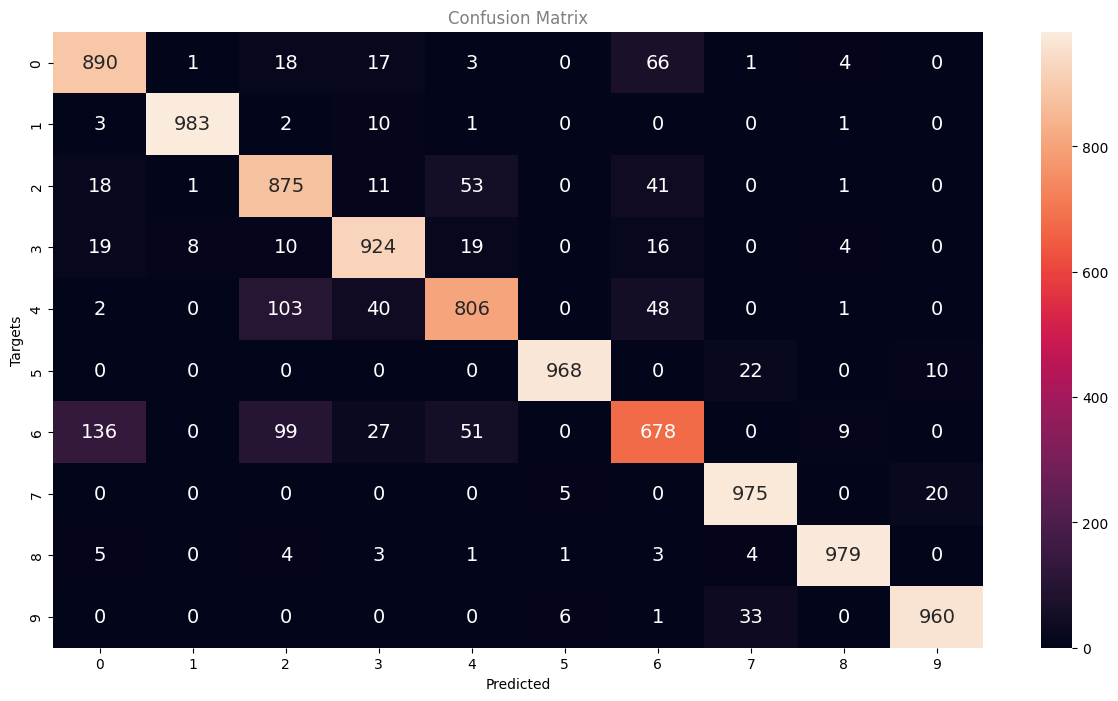

In [358]:
cm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels)

plt.figure(figsize=(15, 8))

sn.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 14})
plt.xlabel('Predicted')
plt.ylabel('Targets')
plt.title(f'Confusion Matrix', color='gray')
plt.show()
